# Support Vector Classifier

In [80]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
np.warnings.filterwarnings('ignore')

from sklearn.tree import plot_tree
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score,\
                            roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.svm import SVC

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [81]:
from Preprocessing import *

In [82]:
df = preprod_tp1(df_data, df_decision)
df = replace_nulls_edad(df, 'media')
# La normalizacion es CLAVE para que SVC converja
df = normalizar_atributos_numericos(df)
df = encodear_atributos_categoricos(df)
df.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes,volveria
0,0,0,1,0.130337,0,1,0.880653,0.000,0.000000,0.000000,0,0,1,0.0,0.0
1,0,0,1,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,0,1,0.2,0.0
2,0,1,0,0.891011,0,1,0.368090,0.000,0.000000,0.040816,0,1,0,0.0,0.0
3,0,0,1,0.510112,0,1,0.368090,0.000,0.000000,0.000000,0,1,1,0.0,0.0
4,0,0,1,0.193258,1,0,0.007538,0.125,0.166667,0.020408,0,1,1,0.2,1.0


## Entrenamiento

In [83]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

In [85]:
params = {'C': np.arange(1, 10), 
          'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
          'gamma': ['scale', 'auto'],
          'degree': np.arange(3, 10)
         }

vector = SVC(probability = True)

rgscv = RandomizedSearchCV(
    vector, params, n_iter=60, scoring='roc_auc', cv=5, return_train_score=True
).fit(X_train, y_train)

In [86]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.847281200199604
Best params {'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 7}


In [87]:
kf = StratifiedKFold(n_splits=5)

test_rocs = []
for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    super_vector = SVC(probability=True, 
        C = rgscv.best_params_['C'],
        kernel = rgscv.best_params_['kernel'],
        gamma = rgscv.best_params_['gamma'],
        degree = rgscv.best_params_['degree'],
    )
    super_vector.fit(X.iloc[train_index], y.iloc[train_index])
    test_roc = roc_auc_score(y.iloc[test_index], super_vector.predict(X.iloc[test_index]))
    print(f"Fold {fold_idx}: AUC ROC score is {test_roc:.4f}")
    test_rocs.append(test_roc)
print(f"Mean test AUC ROC is: {np.mean(test_rocs):.4f}")

Fold 0: AUC ROC score is 0.7208
Fold 1: AUC ROC score is 0.7062
Fold 2: AUC ROC score is 0.7768
Fold 3: AUC ROC score is 0.7572
Fold 4: AUC ROC score is 0.7288
Mean test AUC ROC is: 0.7379


## Métricas

### AUC ROC

In [88]:
roc = roc_auc_score(y_test, super_vector.predict_proba(X_test)[:,1])
print(f"{roc:.4f}")

0.8901


### Accuracy

In [89]:
acc = accuracy_score(y_test, super_vector.predict(X_test))
print(f"{acc:.4f}")

0.8010


### Precision

In [90]:
precision = precision_score(y_test, super_vector.predict(X_test))
print(f"{precision:.4f}")

0.9048


### Recall

In [91]:
recall = recall_score(y_test, super_vector.predict(X_test), pos_label=0)
print(f"{recall:.4f}")

0.9685


### F1-Score

In [92]:
f1 = f1_score(y_test, super_vector.predict(X_test))
print(f"{f1:.4f}")

0.6552


## Matriz de confusión

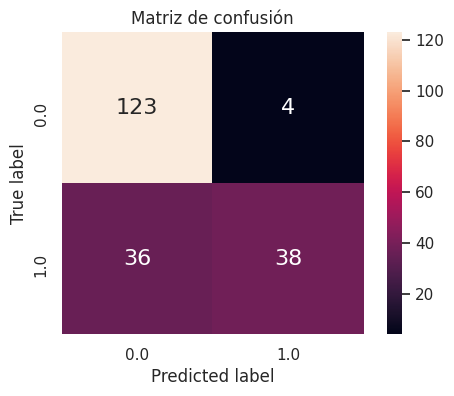

In [94]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusión")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, super_vector.predict(X_test))

## Test Holdout

In [95]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')
holdout.head(5)

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señorita Beatriz Estela,650,mujer,26.0,0,0,"EC0""4536",1,NaN,fiumark_palermo
1,4d,Señorita Elena Herminda,234,mujer,8.0,4,2,569299,4,NaN,fiumark_palermo
2,normal,Señor Humberto Americo,31,hombre,43.0,0,0,"RE""39823",3,NaN,fiumark_chacarita
3,3d,Señor Casiano,552,hombre,30.0,0,0,46657:,3,NaN,fiumark_palermo
4,4d,Señor Gregorio Nicolas,411,hombre,NaN,0,0,56;444,1,NaN,fiumark_palermo


In [96]:
df_h = prepod_tp1_un_df(holdout)
df_h = replace_nulls_edad(df_h, 'media')
df_h = normalizar_atributos_numericos(df_h)
df_h = encodear_atributos_categoricos(df_h)
df_h = df_h.drop(['volveria'], axis=1)
df_h.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,0.751756,0,1,0.344774,0.0,0.0,0.000000,0,0,1,0.0
1,0,0,1,0.264637,0,1,0.063963,0.5,0.4,0.061224,0,0,1,0.6
2,0,1,0,0.026932,1,0,0.609984,0.0,0.0,0.040816,0,1,0,0.0
3,0,1,1,0.637002,1,0,0.407176,0.0,0.0,0.040816,0,0,1,0.0
4,0,0,1,0.471897,1,0,0.450858,0.0,0.0,0.000000,0,0,1,0.0


In [97]:
y_pred = super_vector.predict(df_h)
y_pred

array([0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0.])

In [98]:
(y_pred.shape, df_h.shape)

((90,), (90, 14))

In [99]:
serie_predicha = pd.Series(y_pred, name='volveria') 
serie_predicha = serie_predicha.to_frame()
df_predicho = holdout.join(serie_predicha, how='inner')
cols = ['id_usuario', 'volveria']
df_resultado = df_predicho[cols]
df_resultado.head()

,id_usuario,volveria
0,650,0.0
1,234,0.0
2,31,1.0
3,552,1.0
4,411,0.0


In [100]:
df_resultado.shape

(90, 2)

In [101]:
df_resultado.to_csv('prediccion/SVC_resultado_final.csv')